In [4]:
!pip install catboost category_encoders sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 4.0 MB/s eta 0:00:00


In [6]:
%matplotlib inline
import pandas as pd
from catboost import CatBoostRanker, Pool
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import ndcg_score
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer

### Загрузка данных

[Book Recommendation Dataset](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset)

In [8]:
books_df = pd.read_csv('Books.csv')
books_df.head()

<ipython-input-8-4efc2366e63b>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_df = pd.read_csv('Books.csv')


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [9]:
users_df = pd.read_csv('Users.csv')
users_df.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [10]:
ratings_df = pd.read_csv('Ratings.csv')
ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


Объединим данные.

In [28]:
df = pd.merge(ratings_df, users_df, on='User-ID', how='left')
df = pd.merge(books_df, df, on='ISBN', how='left')

df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2.0,0.0,"stockton, california, usa",18.0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8.0,5.0,"timmins, ontario, canada",NaN
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11400.0,0.0,"ottawa, ontario, canada",49.0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11676.0,8.0,"n/a, n/a, n/a",NaN
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,41385.0,0.0,"sudbury, ontario, canada",NaN


### EDA и предобработка данных

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1032345 entries, 0 to 1032344
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   ISBN                 1032345 non-null  object 
 1   Book-Title           1032345 non-null  object 
 2   Book-Author          1032343 non-null  object 
 3   Year-Of-Publication  1032345 non-null  object 
 4   Publisher            1032343 non-null  object 
 5   Image-URL-S          1032345 non-null  object 
 6   Image-URL-M          1032345 non-null  object 
 7   Image-URL-L          1032341 non-null  object 
 8   User-ID              1031136 non-null  float64
 9   Book-Rating          1031136 non-null  float64
 10  Location             1031136 non-null  object 
 11  Age                  753301 non-null   float64
dtypes: float64(3), object(9)
memory usage: 94.5+ MB


1. Заполнение пропусков в Book-Author и Publisher значением `unknown`

In [29]:
df['Book-Author'] = df['Book-Author'].fillna('unknown')
df['Publisher'] = df['Publisher'].fillna('unknown')

In [31]:
df['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

2. Приведем год к одному формату

In [33]:
df['Year-Of-Publication'] = pd.to_numeric(df['Year-Of-Publication'], errors='coerce')

3. Посмотрим распределения Check Age, Year-Of-Publication и Book-Rating

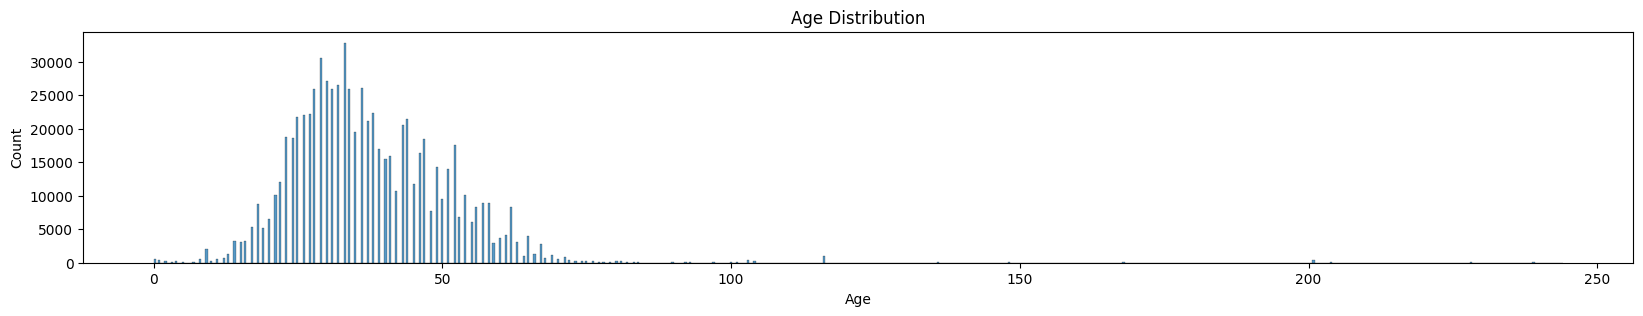

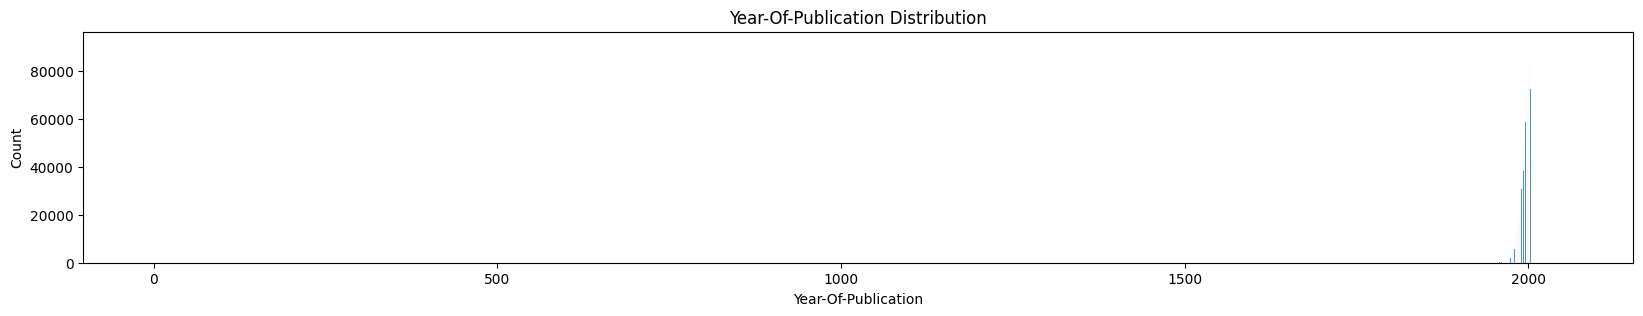

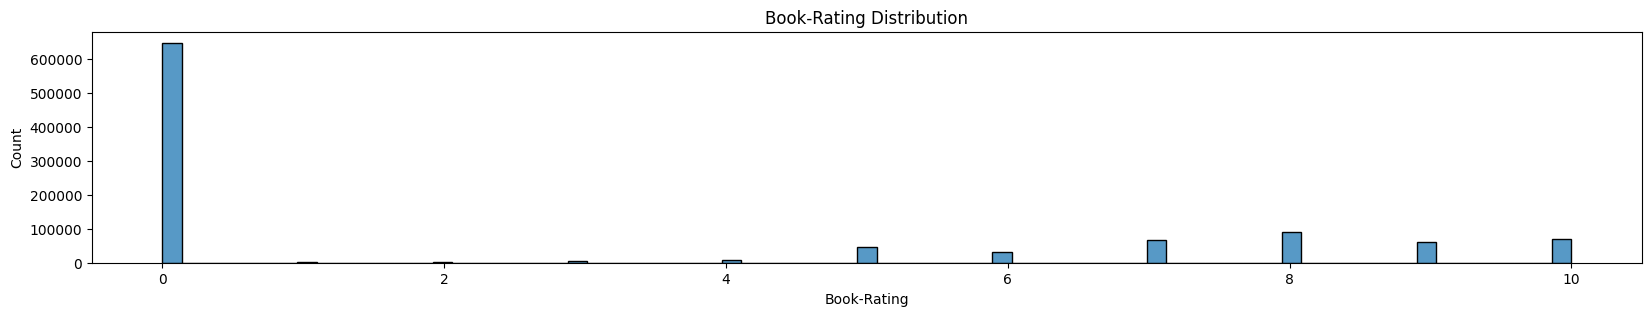

In [34]:
plt.rcParams["figure.figsize"] = (20,3)
sns.histplot(data=df, x='Age')
plt.title('Age Distribution')
plt.show()

sns.histplot(data=df, x='Year-Of-Publication')
plt.title('Year-Of-Publication Distribution')
plt.show()

sns.histplot(data=df, x='Book-Rating')
plt.title('Book-Rating Distribution')
plt.show()


4. Чистка данных:
    - Заменим значения больше 100 в поле Ages, которые могут быть ошибкой, на Nan
    - Заменим значения <= 0 в поле Year-of-Publication медианой, установим максимально возможное значение 2021
    - Удалим строчки с Rating = 0, потому что это означает, что рейтинг не был выставлен
    - Создадим 3 признака (city, state, country) из Location

In [38]:
df['Age'] = np.where(df['Age'] > 100, None, df['Age'])

df['Year-Of-Publication'] = np.where(
    df['Year-Of-Publication'] <= 0,
    np.nanmedian(df['Year-Of-Publication']),
    df['Year-Of-Publication']
    ).clip(0, 2021).astype(str)

df = df[df['Book-Rating'] > 0]

df['city'] = df['Location'].apply(lambda x: x.split(',')[0].strip())
df['state'] = df['Location'].apply(lambda x: x.split(',')[1].strip())
df['country'] = df['Location'].apply(lambda x: x.split(',')[2].strip())

<ipython-input-38-cb27e19e4be0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['city'] = df['Location'].apply(lambda x: x.split(',')[0].strip())
<ipython-input-38-cb27e19e4be0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['state'] = df['Location'].apply(lambda x: x.split(',')[1].strip())
<ipython-input-38-cb27e19e4be0>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

### Train-Validation-Test Split

In [39]:
# создадим список уникальных пользователей
users = df['User-ID'].unique()
random.shuffle(users)
# разделим пользователей на train, validation и test в пропорции 0.7 : 0.1 : 0.2
train_users = users[:int(0.7*len(users))]
val_users = users[int(0.7*len(users)):int(0.8*len(users))]
test_users = users[int(0.8*len(users)):]
# train, val и test df
train_df = df[df['User-ID'].isin(train_users)]
val_df = df[df['User-ID'].isin(val_users)]
test_df = df[df['User-ID'].isin(test_users)]

### Признаки

In [40]:
EXCLUDE_FEATURES = ['city', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L', 'User-ID', 'ISBN', 'Location','Book-Title','Book-Rating']
CATEGORICAL_FEATURES = ['Book-Author', 'Year-Of-Publication', 'Publisher', 'state', 'country']
TARGET = ['Book-Rating']

#### Преобразование признаков

1. Преобразуем текстовый признак `Book-Title` в эмбеддинг

In [42]:
# инициализируем модель для работы с текстом
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# создаем train, val и test эмбеддинги
train_books = train_df.loc[:, ["ISBN", "Book-Title"]].drop_duplicates()
val_books = val_df.loc[:, ["ISBN", "Book-Title"]].drop_duplicates()
test_books = test_df.loc[:, ["ISBN", "Book-Title"]].drop_duplicates()

train_embeddings = model.encode(train_books["Book-Title"].tolist(), normalize_embeddings=True)
val_embeddings = model.encode(val_books["Book-Title"].tolist(), normalize_embeddings=True)
test_embeddings = model.encode(test_books["Book-Title"].tolist(), normalize_embeddings=True)

In [43]:
# сократим размерность с PCA
pca = PCA(n_components=0.8, random_state=42)
train_embeddings = pca.fit_transform(train_embeddings)
val_embeddings = pca.transform(val_embeddings)
test_embeddings = pca.transform(test_embeddings)

In [44]:
train_books = train_df.loc[:, ["ISBN", "Book-Title"]].drop_duplicates()

In [45]:
# добавим эмбеддинги в виде признаков
def add_embeddings(df, embeddings, books):
    embeddings_df = pd.DataFrame(embeddings)
    embeddings_df.columns = [f"Book-Title_{i}" for i in embeddings_df.columns]
    books = pd.merge(books.reset_index(drop=True), embeddings_df, left_index=True, right_index=True)
    return pd.merge(df, books, on=["ISBN", "Book-Title"])

train_df = add_embeddings(train_df, train_embeddings, train_books)
val_df = add_embeddings(val_df, val_embeddings, val_books)
test_df = add_embeddings(test_df, test_embeddings, test_books)

2. Трансформируем категориальные признаки при помощи Catboost Encoder для регрессии
 - мы не используем преобразование Catboost, так как Catboost Ranker использует One-Hot кодировку

In [46]:
encoder = CatBoostEncoder()
train_df[CATEGORICAL_FEATURES] = encoder.fit_transform(train_df[CATEGORICAL_FEATURES], train_df[TARGET])
val_df[CATEGORICAL_FEATURES] = encoder.transform(val_df[CATEGORICAL_FEATURES])
test_df[CATEGORICAL_FEATURES] = encoder.transform(test_df[CATEGORICAL_FEATURES])

### Создаем CatBoost Pools для train и test

In [47]:
FEATURES = [feat for feat in train_df.columns if feat not in EXCLUDE_FEATURES]

# Catboost Ranker требует сортировки по группам (в нашем случае по пользователям)
train_df = train_df.sort_values(by='User-ID')
val_df = val_df.sort_values(by='User-ID')
test_df = test_df.sort_values(by='User-ID')

In [55]:
train_df['User-ID'] = train_df['User-ID'].astype(str)
val_df['User-ID'] = val_df['User-ID'].astype(str)
test_df['User-ID'] = test_df['User-ID'].astype(str)

In [56]:
train_pool = Pool(
    data=train_df[FEATURES],
    label=train_df[TARGET],
    group_id=train_df['User-ID'].tolist(),
)
val_pool = Pool(
    data=val_df[FEATURES],
    label=val_df[TARGET],
    group_id=val_df["User-ID"].tolist(),
)
test_pool = Pool(
    data=test_df[FEATURES],
    group_id=test_df["User-ID"].tolist(),
)

### Обучаем CatBoost Ranker и получаем предсказания

In [57]:
model = CatBoostRanker(loss_function="YetiRank", verbose=100)
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100)
test_df["score"] = model.predict(test_pool)

0:	test: 0.9811843	best: 0.9811843 (0)	total: 2.07s	remaining: 34m 26s
100:	test: 0.9844173	best: 0.9844721 (24)	total: 2m 12s	remaining: 19m 36s
200:	test: 0.9847451	best: 0.9848044 (191)	total: 4m 13s	remaining: 16m 48s
300:	test: 0.9847584	best: 0.9848772 (215)	total: 6m 16s	remaining: 14m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9848772489
bestIteration = 215

Shrink model to first 216 iterations.


In [63]:
test_df.head(10)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,...,Book-Title_78,Book-Title_79,Book-Title_80,Book-Title_81,Book-Title_82,Book-Title_83,Book-Title_84,Book-Title_85,Book-Title_86,score
313,0553582909,Icebound,7.608588,7.549058,7.505404,http://images.amazon.com/images/P/0553582909.0...,http://images.amazon.com/images/P/0553582909.0...,http://images.amazon.com/images/P/0553582909.0...,39.0,8.0,...,0.019571,-0.054422,-0.075207,-0.019454,-0.051074,-0.055347,0.056950,-0.020156,-0.036362,-0.152667
316,0671888587,I'll Be Seeing You,7.439098,7.603978,7.553091,http://images.amazon.com/images/P/0671888587.0...,http://images.amazon.com/images/P/0671888587.0...,http://images.amazon.com/images/P/0671888587.0...,39.0,7.0,...,0.043728,0.040714,0.100485,-0.136795,0.034442,-0.077369,-0.065997,0.045644,-0.104605,-0.243202
375,0440225701,The Street Lawyer,7.591425,7.552332,7.596694,http://images.amazon.com/images/P/0440225701.0...,http://images.amazon.com/images/P/0440225701.0...,http://images.amazon.com/images/P/0440225701.0...,51.0,9.0,...,-0.026519,-0.002653,0.025283,-0.042926,-0.108277,-0.008369,-0.078346,0.040554,0.028082,-0.170438
400,0060914068,"Love, Medicine and Miracles",9.207671,7.625314,7.614641,http://images.amazon.com/images/P/0060914068.0...,http://images.amazon.com/images/P/0060914068.0...,http://images.amazon.com/images/P/0060914068.0...,53.0,3.0,...,0.067721,-0.004870,-0.064415,0.027193,-0.105149,0.031604,-0.034521,-0.021303,0.096928,0.226418
401,0156047624,All the King's Men,8.687358,7.680286,7.691062,http://images.amazon.com/images/P/0156047624.0...,http://images.amazon.com/images/P/0156047624.0...,http://images.amazon.com/images/P/0156047624.0...,53.0,10.0,...,-0.044098,-0.003279,0.000836,-0.067316,0.104739,0.030223,0.065185,-0.040772,-0.009158,0.451759
402,0245542957,Pacific Northwest,7.623012,7.578155,6.905753,http://images.amazon.com/images/P/0245542957.0...,http://images.amazon.com/images/P/0245542957.0...,http://images.amazon.com/images/P/0245542957.0...,53.0,6.0,...,-0.042885,-0.025369,0.063600,0.000728,-0.021946,0.052410,0.169326,-0.018425,-0.014945,-0.396257
403,0380715899,A Soldier of the Great War,8.354100,7.570929,7.590481,http://images.amazon.com/images/P/0380715899.0...,http://images.amazon.com/images/P/0380715899.0...,http://images.amazon.com/images/P/0380715899.0...,53.0,9.0,...,0.034731,0.054743,0.024635,0.012116,0.013011,-0.000379,-0.078667,-0.101409,-0.001218,0.251937
404,0671623249,LONESOME DOVE,7.741390,7.680069,7.553091,http://images.amazon.com/images/P/0671623249.0...,http://images.amazon.com/images/P/0671623249.0...,http://images.amazon.com/images/P/0671623249.0...,56.0,7.0,...,-0.003379,0.090702,0.032094,-0.097874,-0.028346,0.060194,-0.004044,-0.053745,0.097578,-0.009807
413,0679865691,Haveli (Laurel Leaf Books),6.402557,7.512272,7.894492,http://images.amazon.com/images/P/0679865691.0...,http://images.amazon.com/images/P/0679865691.0...,http://images.amazon.com/images/P/0679865691.0...,56.0,9.0,...,-0.015423,-0.061830,0.068250,-0.026559,0.011002,0.015219,-0.011394,0.028643,-0.025009,-0.360036
517,0375410538,Anil's Ghost,7.965728,7.549058,7.657275,http://images.amazon.com/images/P/0375410538.0...,http://images.amazon.com/images/P/0375410538.0...,http://images.amazon.com/images/P/0375410538.0...,81.0,5.0,...,-0.001696,0.050196,-0.023727,-0.051597,0.058835,-0.016378,0.026022,-0.008559,0.065350,0.154463


#### Feature Importance

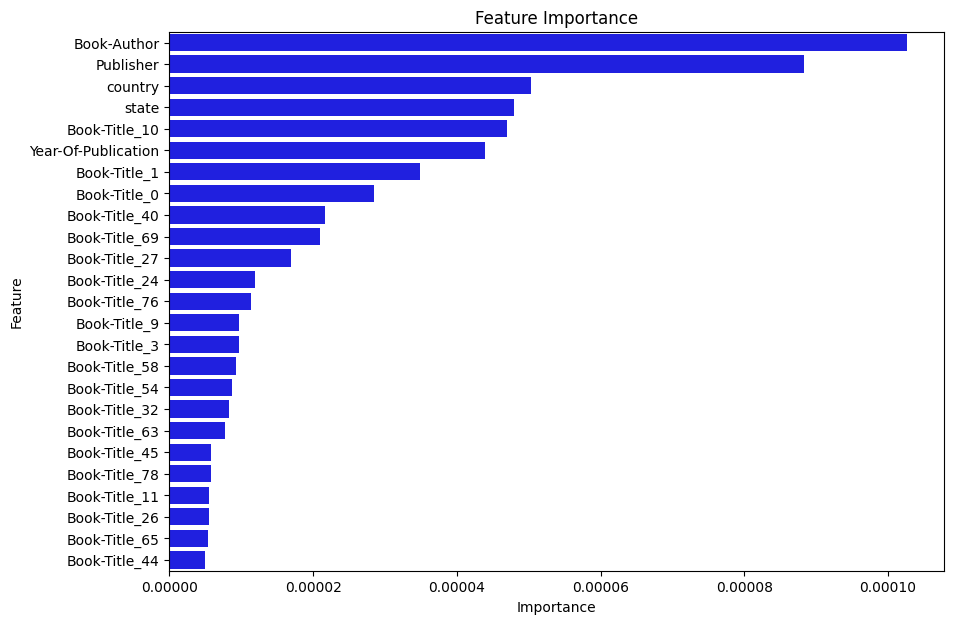

In [58]:
feature_importance = model.get_feature_importance(data=train_pool, verbose=0)
feature_importance_df = (
        pd.DataFrame(
            feature_importance,
            index=FEATURES,
            columns=["Importance"],
        )
        .sort_values(by="Importance", ascending=False)
        .reset_index()
    )

# Set the figure size
plt.figure(figsize=(10, 7))

# plot a bar chart
sns.barplot(
    x="Importance",
    y="index",
    data=feature_importance_df.iloc[:25, :],
    color="blue",
)
plt.title("Feature Importance")
plt.ylabel("Feature")
plt.show()


#### Calculate nDCG

In [76]:
users_count = test_df.groupby('User-ID')['ISBN'].count()
users = users_count[users_count.values > 1].index

In [64]:
def get_user_ndcg(user_id):
    true_relevance = np.asarray([test_df[test_df['User-ID'] == user_id][TARGET[0]].tolist()])
    y_relevance = np.asarray([test_df[test_df['User-ID'] == user_id]['score'].tolist()])

    return ndcg_score(true_relevance, y_relevance)

In [79]:
ndcg_scores = []
for user_id in users:
    ndcg_scores.append(get_user_ndcg(user_id))
np.mean(ndcg_scores)

0.9643419570683528